In [1]:
import os
import shutil
from pathlib import Path

# Define input and output paths
source_base = Path(r"C:\Users\reddy\Downloads\dataset")  # Change to your base dataset path
target_base = Path(r"C:\Users\reddy\Downloads\ndataset")  # Change to desired YOLO dataset path

# YOLO structure
images_train = target_base / "images/train"
images_val = target_base / "images/val"
labels_train = target_base / "labels/train"
labels_val = target_base / "labels/val"

# Create directories
for path in [images_train, images_val, labels_train, labels_val]:
    path.mkdir(parents=True, exist_ok=True)

# Helper function to copy image and label files
def copy_files(src_dir, dst_img_dir, dst_lbl_dir):
    for cls_folder in os.listdir(src_dir):
        cls_path = src_dir / cls_folder
        if not cls_path.is_dir():
            continue
        for file in cls_path.glob("*.jpg"):  # Change to *.png if using PNG images
            img_dst = dst_img_dir / file.name
            lbl_src = file.with_suffix(".txt")
            lbl_dst = dst_lbl_dir / lbl_src.name

            shutil.copy(file, img_dst)  # Copy image file
            if lbl_src.exists():  # Copy corresponding label if exists
                shutil.copy(lbl_src, lbl_dst)

# Copy training data
copy_files(source_base / "train", images_train, labels_train)

# Copy test/validation data
copy_files(source_base / "test", images_val, labels_val)

print("Dataset successfully arranged into YOLO format at 'dataset_yolo/' with images and labels split into train/val folders.")


Dataset successfully arranged into YOLO format at 'dataset_yolo/' with images and labels split into train/val folders.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np
import os

# Configuration
train_path = r'C:\Users\reddy\Downloads\dataset\train'
test_path = r'C:\Users\reddy\Downloads\dataset\test'
num_epochs = 5
batch_size = 32
lr = 0.001

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load train dataset
full_dataset = datasets.ImageFolder(root=train_path, transform=transform)

# Class Info
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Number of Classes: {num_classes}")
print(f"Class Names: {class_names}")

# Split into train and val
targets = full_dataset.targets
train_idx, val_idx = train_test_split(
    np.arange(len(targets)), test_size=0.2, stratify=targets, random_state=42
)
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load test dataset
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pretrained MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Freeze feature extractor
for param in model.features.parameters():
    param.requires_grad = False

# Modify classifier
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=lr)

# Path to save the best model
best_model_path = "mobilenet_best.pth"

# Initialize variables
best_val_acc = 0.0

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

        print(f"  [Train] Batch {i+1}/{len(train_loader)} | Loss: {loss.item():.4f} | Acc: {100 * train_correct / train_total:.2f}%")

    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(train_loader)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for j, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

            print(f"  [Val  ] Batch {j+1}/{len(val_loader)} | Loss: {loss.item():.4f} | Acc: {100 * val_correct / val_total:.2f}%")

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Accuracy: {val_accuracy:.2f}%")

    # If the validation accuracy is the best, save the model
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✅ Best model saved to {best_model_path}")
    else:
        print(f"  ❌ No improvement in validation accuracy")

# Load the best model weights
model.load_state_dict(torch.load(best_model_path))
print(f"\nBest model loaded with Val Accuracy: {best_val_acc:.2f}%")

# Evaluate on Test Set
model.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (preds == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"\nFinal Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


Number of Classes: 10
Class Names: ['freshapples', 'freshbanana', 'freshcucumber', 'freshoranges', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottencucumber', 'rottenoranges', 'rottentomato']


C:\Users\reddy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\reddy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  [Train] Batch 1/469 | Loss: 2.2654 | Acc: 15.62%
  [Train] Batch 2/469 | Loss: 2.1331 | Acc: 18.75%
  [Train] Batch 3/469 | Loss: 1.9063 | Acc: 21.88%
  [Train] Batch 4/469 | Loss: 2.1305 | Acc: 26.56%
  [Train] Batch 5/469 | Loss: 1.9914 | Acc: 30.62%
  [Train] Batch 6/469 | Loss: 1.8138 | Acc: 34.38%
  [Train] Batch 7/469 | Loss: 1.9191 | Acc: 35.71%
  [Train] Batch 8/469 | Loss: 1.7948 | Acc: 35.55%
  [Train] Batch 9/469 | Loss: 1.5722 | Acc: 37.50%
  [Train] Batch 10/469 | Loss: 1.5250 | Acc: 39.06%
  [Train] Batch 11/469 | Loss: 1.7485 | Acc: 39.49%
  [Train] Batch 12/469 | Loss: 1.5572 | Acc: 42.45%
  [Train] Batch 13/469 | Loss: 1.6895 | Acc: 43.03%
  [Train] Batch 14/469 | Loss: 1.0971 | Acc: 45.54%
  [Train] Batch 15/469 | Loss: 1.3525 | Acc: 46.67%
  [Train] Batch 16/469 | Loss: 1.1852 | Acc: 48.44%
  [Train] Batch 17/469 | Loss: 1.1297 | Acc: 49.82%
  [Train] Batch 18/469 | Loss: 1.1125 | Acc: 51.04%
  [Train] Batch 19/469 | Loss: 0.9735 | Acc: 52.80%
  [Train] Batch 20/46

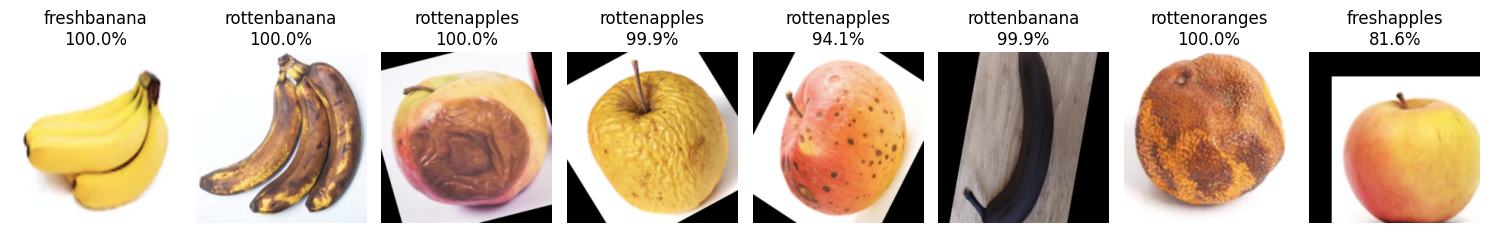

In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

# --- Config ---
model_path = 'mobilenet_best.pth'
dataset_path = r'C:\Users\reddy\Downloads\dataset\train'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8  # only one batch

# --- Transforms ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Load dataset ---
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# --- Load model ---
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# --- Inference on one batch ---
images, labels = next(iter(loader))
images = images.to(device)

with torch.no_grad():
    outputs = model(images)
    probs = torch.softmax(outputs, dim=1)
    confs, preds = torch.max(probs, 1)

# --- Display Results ---
images = images.cpu()
fig, axs = plt.subplots(1, batch_size, figsize=(15, 4))
for i in range(batch_size):
    img = images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"{class_names[preds[i]]}\n{confs[i]*100:.1f}%")

plt.tight_layout()
plt.show()
